In [2]:
!pip install spotipy

     |████████████████████████████████| 153kB 6.4MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# **Authorizing Client Credential**

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [5]:
client_id = '89fef1b3332b42e58a2bf14366523bc6'
client_secret = '481f2262c51c4e1b95f69925aa29c899'

In [6]:
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

**Take my "Your Top Songs 2020" Playlist**

In [7]:
# take id from playlist
playlist_id = 'spotify:playlist:37i9dQZF1EM0sAXSXDg2Jk'
results = sp.playlist(playlist_id)

In [8]:
# example data
results['tracks']['items'][0]['track']['album']['name']

'Pieces of Us (feat. King Princess)'

The results can be exported as json file. After that we can see what is the stucture of the file. We need to understand the structure of the data so that we can make csv file out of it.

In [10]:
import json

with open("data.json", "w") as outfile:
    json.dump(results, outfile)

# **Convert into Dataframe**

In [11]:
ids  = []

# get track's id
for item in results['tracks']['items']:
  track = item['track']['id']
  ids.append(track)

song_meta = {
    'id': [],
    'album': [],
    'name': [],
    'artist': [],
    'explicit': [],
    'popularity': []
}

for song in ids:
  # get single track given track's ID
  track = sp.track(song)

  # song id
  song_meta['id'].append(song)

  # album name
  album = track['album']['name']
  song_meta['album'] += [album]

  # song name
  song =  track['name']
  song_meta['name'] += [song]

  # artist name
  artist = ', '.join([singer['name'] for singer in track['artists']])
  song_meta['artist'] += [artist]

  # explicit
  explicit = track['explicit']
  song_meta['explicit'].append(explicit)

  # popularity
  popularity = track['popularity']
  song_meta['popularity'].append(popularity)

In [12]:
import pandas as pd
import numpy as np

df = pd.DataFrame.from_dict(song_meta)

In [13]:
df.head()

,id,album,name,artist,explicit,popularity
0,0ac6wpfha90oah72SCNTPV,Pieces of Us (feat. King Princess),Pieces of Us (feat. King Princess),"Mark Ronson, King Princess",False,39
1,3cl6BsTDeeGRbgug5TXrvg,Shoot Me : Youth Part 1,Shoot Me,DAY6,False,66
2,6PUYqQtGWVAovZrLC9BIqt,Youngblood (Deluxe),Babylon,5 Seconds of Summer,False,61
3,4aceMabp5rzZYoKKXsUffr,MOONRISE,누군가 필요해 I Need Somebody,DAY6,False,62
4,1YlulsUKDduOmC7WxvXYPW,Free Time,Painkiller,Ruel,False,75


## **Add song features using function from spotipy**

In [14]:
# song features
features = sp.audio_features(song_meta['id'])
features = pd.DataFrame.from_dict(features)

In [15]:
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.571,0.747,0,-8.708,0,0.0680,0.15300,0.000000,0.1860,0.350,101.972,audio_features,0ac6wpfha90oah72SCNTPV,spotify:track:0ac6wpfha90oah72SCNTPV,https://api.spotify.com/v1/tracks/0ac6wpfha90o...,https://api.spotify.com/v1/audio-analysis/0ac6...,206401,4
1,0.583,0.916,1,-1.396,1,0.1490,0.06830,0.000000,0.0489,0.732,167.933,audio_features,3cl6BsTDeeGRbgug5TXrvg,spotify:track:3cl6BsTDeeGRbgug5TXrvg,https://api.spotify.com/v1/tracks/3cl6BsTDeeGR...,https://api.spotify.com/v1/audio-analysis/3cl6...,175837,4
2,0.521,0.884,4,-2.931,0,0.0403,0.00155,0.000002,0.2090,0.494,92.988,audio_features,6PUYqQtGWVAovZrLC9BIqt,spotify:track:6PUYqQtGWVAovZrLC9BIqt,https://api.spotify.com/v1/tracks/6PUYqQtGWVAo...,https://api.spotify.com/v1/audio-analysis/6PUY...,213186,4
3,0.419,0.532,5,-4.759,0,0.0344,0.12700,0.000000,0.0785,0.337,184.197,audio_features,4aceMabp5rzZYoKKXsUffr,spotify:track:4aceMabp5rzZYoKKXsUffr,https://api.spotify.com/v1/tracks/4aceMabp5rzZ...,https://api.spotify.com/v1/audio-analysis/4ace...,218737,4
4,0.683,0.420,5,-6.510,1,0.0542,0.08750,0.000000,0.2250,0.469,128.621,audio_features,1YlulsUKDduOmC7WxvXYPW,spotify:track:1YlulsUKDduOmC7WxvXYPW,https://api.spotify.com/v1/tracks/1YlulsUKDduO...,https://api.spotify.com/v1/audio-analysis/1Ylu...,213507,4


In [16]:
# merge two df
playlist_df = df.merge(features)
playlist_df.head()

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,0ac6wpfha90oah72SCNTPV,Pieces of Us (feat. King Princess),Pieces of Us (feat. King Princess),"Mark Ronson, King Princess",False,39,0.571,0.747,0,-8.708,0,0.0680,0.15300,0.000000,0.1860,0.350,101.972,audio_features,spotify:track:0ac6wpfha90oah72SCNTPV,https://api.spotify.com/v1/tracks/0ac6wpfha90o...,https://api.spotify.com/v1/audio-analysis/0ac6...,206401,4
1,3cl6BsTDeeGRbgug5TXrvg,Shoot Me : Youth Part 1,Shoot Me,DAY6,False,66,0.583,0.916,1,-1.396,1,0.1490,0.06830,0.000000,0.0489,0.732,167.933,audio_features,spotify:track:3cl6BsTDeeGRbgug5TXrvg,https://api.spotify.com/v1/tracks/3cl6BsTDeeGR...,https://api.spotify.com/v1/audio-analysis/3cl6...,175837,4
2,6PUYqQtGWVAovZrLC9BIqt,Youngblood (Deluxe),Babylon,5 Seconds of Summer,False,61,0.521,0.884,4,-2.931,0,0.0403,0.00155,0.000002,0.2090,0.494,92.988,audio_features,spotify:track:6PUYqQtGWVAovZrLC9BIqt,https://api.spotify.com/v1/tracks/6PUYqQtGWVAo...,https://api.spotify.com/v1/audio-analysis/6PUY...,213186,4
3,4aceMabp5rzZYoKKXsUffr,MOONRISE,누군가 필요해 I Need Somebody,DAY6,False,62,0.419,0.532,5,-4.759,0,0.0344,0.12700,0.000000,0.0785,0.337,184.197,audio_features,spotify:track:4aceMabp5rzZYoKKXsUffr,https://api.spotify.com/v1/tracks/4aceMabp5rzZ...,https://api.spotify.com/v1/audio-analysis/4ace...,218737,4
4,1YlulsUKDduOmC7WxvXYPW,Free Time,Painkiller,Ruel,False,75,0.683,0.420,5,-6.510,1,0.0542,0.08750,0.000000,0.2250,0.469,128.621,audio_features,spotify:track:1YlulsUKDduOmC7WxvXYPW,https://api.spotify.com/v1/tracks/1YlulsUKDduO...,https://api.spotify.com/v1/audio-analysis/1Ylu...,213507,4


## **Export CSV**

In [20]:
# export csv
playlist_df.to_csv ('playlist.csv', header=True)

# **EDA**

**Data Preprocessing**

In [21]:
playlist_df['duration_ms'] /= 60000 

In [22]:
playlist_df = playlist_df.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)

In [23]:
playlist_df.head()

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0ac6wpfha90oah72SCNTPV,Pieces of Us (feat. King Princess),Pieces of Us (feat. King Princess),"Mark Ronson, King Princess",False,39,0.571,0.747,0,-8.708,0,0.0680,0.15300,0.000000,0.1860,0.350,101.972,3.440017,4
1,3cl6BsTDeeGRbgug5TXrvg,Shoot Me : Youth Part 1,Shoot Me,DAY6,False,66,0.583,0.916,1,-1.396,1,0.1490,0.06830,0.000000,0.0489,0.732,167.933,2.930617,4
2,6PUYqQtGWVAovZrLC9BIqt,Youngblood (Deluxe),Babylon,5 Seconds of Summer,False,61,0.521,0.884,4,-2.931,0,0.0403,0.00155,0.000002,0.2090,0.494,92.988,3.553100,4
3,4aceMabp5rzZYoKKXsUffr,MOONRISE,누군가 필요해 I Need Somebody,DAY6,False,62,0.419,0.532,5,-4.759,0,0.0344,0.12700,0.000000,0.0785,0.337,184.197,3.645617,4
4,1YlulsUKDduOmC7WxvXYPW,Free Time,Painkiller,Ruel,False,75,0.683,0.420,5,-6.510,1,0.0542,0.08750,0.000000,0.2250,0.469,128.621,3.558450,4


In [24]:
playlist_df.shape

(100, 19)

In [25]:
playlist_df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000
mean,60.640000,0.623230,0.686760,5.530000,-5.517540,0.460000,0.077901,0.155486,0.022995,0.196531,0.50123,124.222180,3.445558,3.95000
std,15.722672,0.132309,0.188587,3.611024,2.929293,0.500908,0.067483,0.194878,0.128259,0.152936,0.19839,30.084012,0.506738,0.35887
min,0.000000,0.288000,0.163000,0.000000,-19.117000,0.000000,0.027600,0.000300,0.000000,0.033500,0.11400,70.956000,2.148600,1.00000
25%,51.750000,0.559250,0.558000,2.000000,-6.858250,0.000000,0.036675,0.013625,0.000000,0.092400,0.34750,99.997500,3.162221,4.00000
50%,63.000000,0.639500,0.724000,6.000000,-4.743500,0.000000,0.054300,0.093650,0.000000,0.127000,0.50950,120.018000,3.396783,4.00000
75%,70.250000,0.705500,0.842000,9.000000,-3.686500,1.000000,0.093125,0.222000,0.000046,0.261500,0.64275,146.229000,3.691925,4.00000
max,87.000000,0.914000,0.978000,11.000000,-0.995000,1.000000,0.445000,0.902000,0.910000,0.691000,0.92300,199.692000,4.983550,5.00000


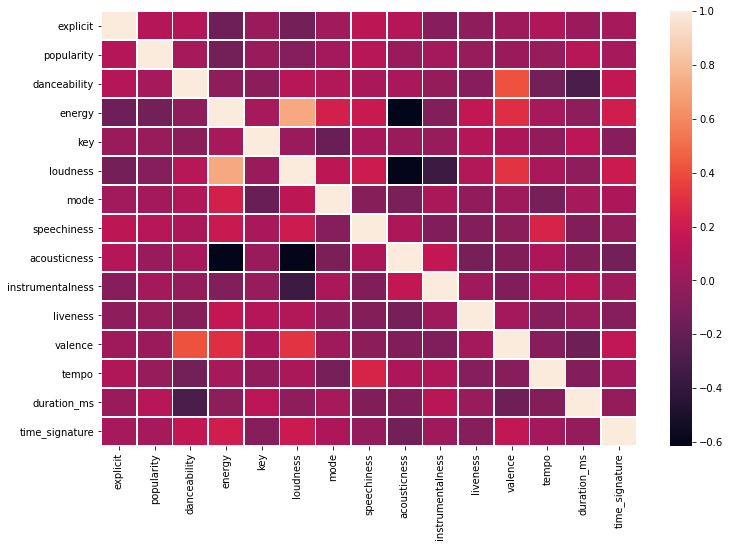

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# find the correlation among
# the columns using pearson method
cor = playlist_df.corr(method ='pearson')

fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(cor, linewidth=0.5)
plt.show()

from heatmap we can see several data that have low correlation between them such as energy with acousticness, loudness with acousticness

# **Data Analysis**

**My Top 5 Artist in 2020**

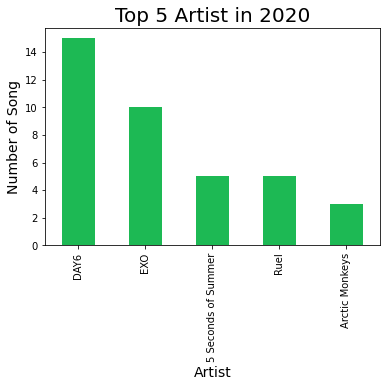

In [47]:
artist = df.artist.value_counts()[:5]
artist.plot(kind = 'bar', color = '#1DB954')

plt.xlabel('Artist', fontsize = 14)
plt.ylabel('Number of Song', fontsize = 14)
plt.title("Top 5 Artist in 2020", size=20)
plt.show()

**Expliciticy**

my top 5 artist in 2020 is mostly boyband and band. Day6 and EXO are korean music boy group, 5SOS and Arctic Monkeys are band, and Ruel is a solo artist. 

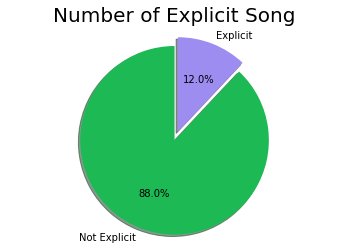

In [59]:
label = ['Not Explicit', 'Explicit']
explicit = df['explicit'].value_counts().tolist()
color = ['#1DB954', '#9D8DF1']
fig1, ax1 = plt.subplots()
explode = (0, 0.1) 

ax1.pie(explicit, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=color)
plt.title("Number of Explicit Song", size=20)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

fyuhhh...

**Mean Values from Song Features**

In [31]:
song_features = playlist_df[['danceability', 'energy', 'loudness', 'speechiness', 
                             'acousticness', 'instrumentalness', 'liveness', 'valence',
                             'tempo']]

In [32]:
from sklearn.preprocessing import MinMaxScaler

# normalization
min_max_scaler = MinMaxScaler()
song_features.loc[:] = min_max_scaler.fit_transform(song_features.loc[:])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


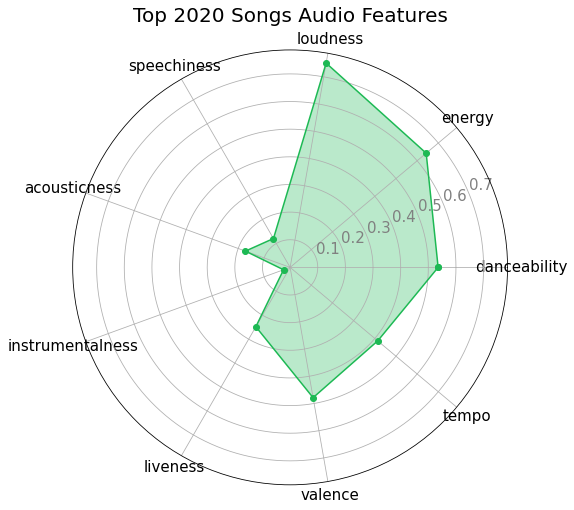

In [45]:
import math 

# plot size
fig = plt.figure(figsize=(12,8))

# convert column names into a list
categories = song_features.columns.to_list()
# number of categories
N = len(categories)

# create a list with the average of all features
value = song_features.mean().to_list()

# close the circle
# and append the start value to the end.
value.append(value[0])

# calculate angle for each category
angles = [n/float(N)*2*math.pi for n in range(N)]
angles.append(angles[0])

# plot
plt.polar(angles, value,  'o-', color="#1DB954")
plt.fill(angles, value, alpha=0.3, facecolor='#1DB954')

plt.title('Top 2020 Songs Audio Features', size=20)

plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()

Text(0.5, 1.0, 'Mean of My Audio Features')

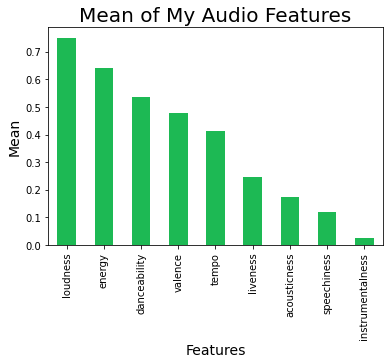

In [48]:
song_features.mean().sort_values(ascending=False).plot(kind = 'bar', color='#1DB954')
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Mean', fontsize = 14)
plt.title("Mean of My Audio Features", size=20)

looks like i really love loud and energetic music. It gaves me energy hahaha

**Valence**

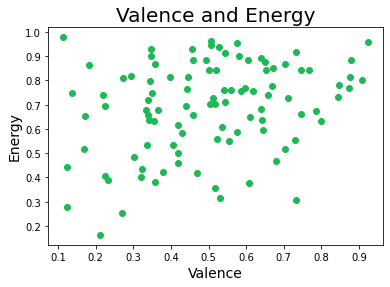

In [50]:
fig, ax = plt.subplots()

x = playlist_df['valence']
y = playlist_df['energy']

plt.scatter(x, y, c='#1DB954')
plt.xlabel('Valence', fontsize = 14)
plt.ylabel('Energy', fontsize = 14)
plt.title("Valence and Energy", size=20)
plt.show()

Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). This plot shows that i listed to diverse song